In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

from latex import to_latex_topN, to_markdown_topN

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
pd.options.display.max_rows = 6
pd.options.display.max_columns = 8

In [2]:
df = pd.read_csv('../data/results_and_quality_val2017.csv', index_col=0)
df

,quality,model_config,AP,AP50,...,peak_signal_noise_ratio,structural_similarity,filesize,B_per_kpx
0,1,faster_rcnn_R_101_C4,0.689,1.236,...,21.205,0.539,7203.782,9.291
1,1,faster_rcnn_R_101_DC5,0.740,1.303,...,21.205,0.539,7203.782,9.291
2,1,faster_rcnn_R_101_FPN,0.687,1.211,...,21.205,0.539,7203.782,9.291
...,...,...,...,...,...,...,...,...,...
897,100,faster_rcnn_X_101_32x8d_FPN,39.678,57.007,...,56.273,0.999,257475.181,325.305
898,100,retinanet_R_101_FPN,39.870,60.102,...,56.273,0.999,257475.181,325.305
899,100,retinanet_R_50_FPN,37.925,57.872,...,56.273,0.999,257475.181,325.305


## Find model "ranking"
And the AP values: overall and stratified by object size.

### Baseline - max values

In [3]:
max_pivot = df.pivot_table(index='model_config', values=['AP', 'APl', 'APm', 'APs'], aggfunc='max').sort_values('AP', ascending=False)
to_latex_topN(max_pivot, caption='The best (baseline) results for all models.', label='table:bestAP', 
    print=False,  # change here if needed
)
to_markdown_topN(max_pivot)

| model_config                |     AP |    APl |    APm |    APs |
|:----------------------------|-------:|-------:|-------:|-------:|
| retinanet_R_101_FPN         | **39.874** | 51.873 | **43.561** | **23.878** |
| faster_rcnn_X_101_32x8d_FPN | 39.716 | 52.175 | 43.046 | 22.689 |
| faster_rcnn_R_101_C4        | 38.532 | **53.82**  | 42.807 | 19.135 |
| faster_rcnn_R_101_FPN       | 38.402 | 51.388 | 42.151 | 20.878 |
| faster_rcnn_R_101_DC5       | 38.33  | 52.37  | 42.846 | 19.403 |
| retinanet_R_50_FPN          | 37.932 | 49.946 | 41.341 | 22.69  |
| faster_rcnn_R_50_DC5        | 36.831 | 50.579 | 41.379 | 18.3   |
| faster_rcnn_R_50_FPN        | 36.696 | 49.427 | 40.196 | 19.123 |
| faster_rcnn_R_50_C4         | 35.99  | 51.09  | 39.902 | 17.565 |

### Average values over Q = 1..100

In [4]:
avg_pivot = df.pivot_table(index='model_config', values=['AP', 'APl', 'APm', 'APs']).sort_values('AP', ascending=False)
to_latex_topN(avg_pivot, caption='The average scores for all models over all $Q \in [1 .. 100]$.', 
    label='table:avgAP', float_format='%.3f',
    print=False,
)
to_markdown_topN(avg_pivot)

| model_config                |      AP |     APl |     APm |     APs |
|:----------------------------|--------:|--------:|--------:|--------:|
| retinanet_R_101_FPN         | **32.5762** | 43.7132 | **35.7326** | **17.7179** |
| faster_rcnn_X_101_32x8d_FPN | 31.7029 | 42.9914 | 34.573  | 16.1605 |
| faster_rcnn_R_101_C4        | 31.1404 | **45.0433** | 34.6249 | 13.8174 |
| faster_rcnn_R_101_DC5       | 30.9534 | 43.4948 | 34.4607 | 14.2538 |
| retinanet_R_50_FPN          | 30.8176 | 41.8428 | 33.4757 | 16.8814 |
| faster_rcnn_R_101_FPN       | 30.5789 | 42.4045 | 33.4964 | 15.0359 |
| faster_rcnn_R_50_DC5        | 29.4687 | 41.4293 | 32.831  | 13.4618 |
| faster_rcnn_R_50_FPN        | 29.0224 | 40.2777 | 31.793  | 13.9759 |
| faster_rcnn_R_50_C4         | 28.7164 | 41.9581 | 31.7068 | 12.4543 |

### Interactive search for rank perturbations, by Q cut-off

Check the order deviaton from max, by adjusting cutoff Quality for Average AP:

In [5]:
@interact
def average_consistent_with_max(cutoff=(1, 70)):
    cut_pivot = df[df.quality >= cutoff].pivot_table(index='model_config', values=['AP']).sort_values('AP', ascending=False)
    change = max_pivot.index != cut_pivot.index
    print(f'For cutoff Q >= {cutoff}:', end=' ')
    if not change.any():
        print('Same ordering as max_pivot')
        return
    places = np.where(change)[0] + 1
    old = max_pivot.index[change].to_numpy()
    d = dict(zip(old, places))
    new = cut_pivot.index[change].to_numpy()
    new_places = cut_pivot.index[change].map(d).to_numpy()
    print('Places', places)
    print(old)
    print('become', new_places)
    print(new)

interactive(children=(IntSlider(value=35, description='cutoff', max=70, min=1), Output()), _dom_classes=('widg…

In [6]:
@interact
def average_consistent_with_max(quality=(1, 100)):
    cut_pivot = df[df.quality == quality].pivot_table(index='model_config', values=['AP']).sort_values('AP', ascending=False)
    change = max_pivot.index != cut_pivot.index
    print(f'For quality Q == {quality}:', end=' ')
    if not change.any():
        print('Same ordering as max_pivot')
        return
    places = np.where(change)[0] + 1
    old = max_pivot.index[change].to_numpy()
    d = dict(zip(old, places))
    new = cut_pivot.index[change].to_numpy()
    new_places = cut_pivot.index[change].map(d).to_numpy()
    print('Places', places)
    print(old)
    print('become', new_places)
    print(new)

interactive(children=(IntSlider(value=50, description='quality', min=1), Output()), _dom_classes=('widget-inte…

## WiP

Below follows unfinished stuff.

###  Table of AP by Q

In [7]:
aps = df.pivot(index='quality', columns='model_config', values='AP')
#aps = aps.reindex(columns=max_pivot.index)
aps

model_config,faster_rcnn_R_101_C4,faster_rcnn_R_101_DC5,faster_rcnn_R_101_FPN,faster_rcnn_R_50_C4,...,faster_rcnn_R_50_FPN,faster_rcnn_X_101_32x8d_FPN,retinanet_R_101_FPN,retinanet_R_50_FPN
quality,,,,,,,,,
1,0.689,0.740,0.687,0.631,...,0.584,0.582,1.024,0.956
2,0.691,0.749,0.692,0.649,...,0.586,0.581,1.027,0.957
3,1.071,1.042,0.925,0.891,...,0.802,0.751,1.375,1.295
...,...,...,...,...,...,...,...,...,...
98,38.472,38.233,38.402,35.955,...,36.696,39.685,39.848,37.931
99,38.483,38.277,38.385,35.889,...,36.666,39.716,39.853,37.921
100,38.510,38.330,38.400,35.940,...,36.667,39.678,39.870,37.925


### Plotting the AP against Q

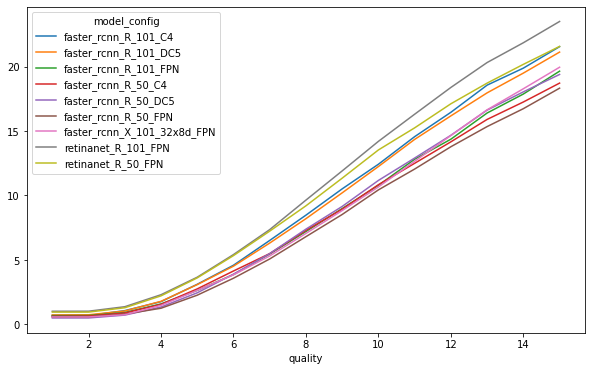

In [8]:
aps[:15].plot();

In [9]:
aps[aps.index % 5 == 0]

model_config,faster_rcnn_R_101_C4,faster_rcnn_R_101_DC5,faster_rcnn_R_101_FPN,faster_rcnn_R_50_C4,...,faster_rcnn_R_50_FPN,faster_rcnn_X_101_32x8d_FPN,retinanet_R_101_FPN,retinanet_R_50_FPN
quality,,,,,,,,,
5,3.115,3.090,2.642,2.757,...,2.270,2.647,3.665,3.612
10,12.424,12.247,10.787,10.837,...,10.436,10.665,14.199,13.533
15,21.542,21.121,19.641,18.716,...,18.323,19.947,23.496,21.560
...,...,...,...,...,...,...,...,...,...
90,38.081,38.055,38.255,35.746,...,36.379,39.378,39.640,37.724
95,38.327,38.246,38.243,35.865,...,36.566,39.565,39.866,37.874
100,38.510,38.330,38.400,35.940,...,36.667,39.678,39.870,37.925


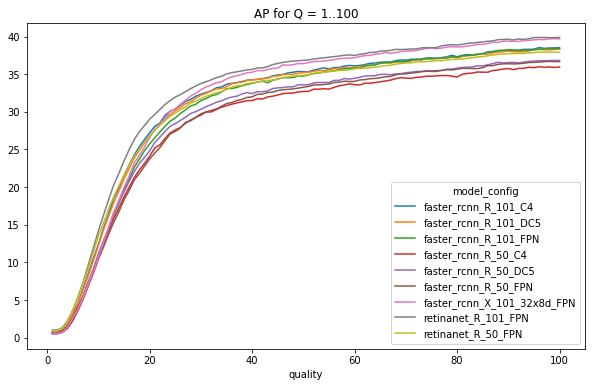

In [10]:
p = aps.plot(title='AP for Q = 1..100');
p.get_figure().savefig('models_AP_001_100.pdf')
p;

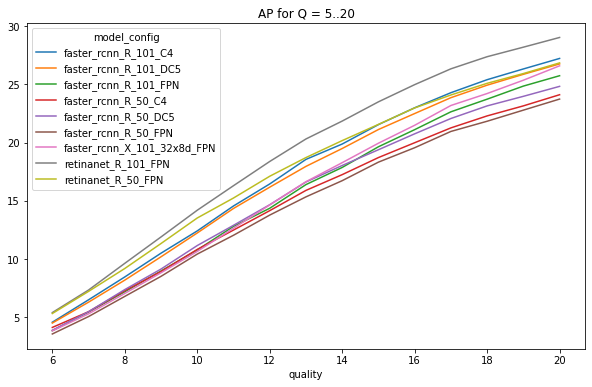

In [11]:
p = aps[5:20].plot(title='AP for Q = 5..20');
p.get_figure().savefig('models_AP_005_020.pdf')
p;

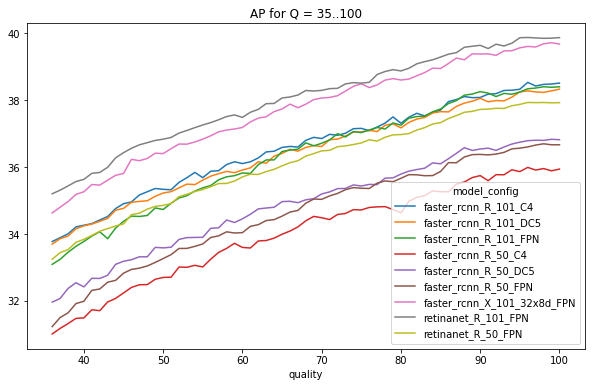

In [12]:
p = aps[35:].plot(title='AP for Q = 35..100');
p.get_figure().savefig('models_AP_035_100.pdf')
p;

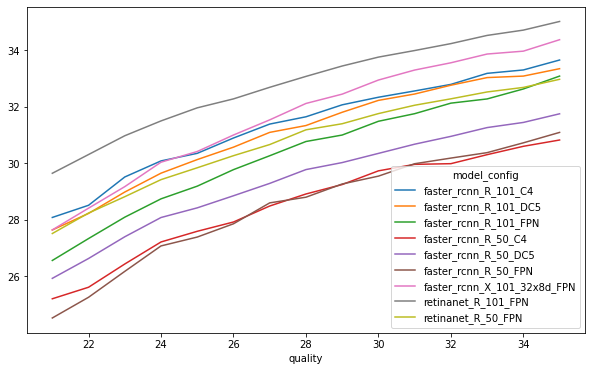

In [13]:
aps[20:35].plot();

## Plot AP against RMSE

In [14]:
#aps[20:35].plot(x='');

In [15]:
df.columns

Index(['quality', 'model_config', 'AP', 'AP50', 'AP75', 'APs', 'APm', 'APl',
       'AP-person', 'AP-bicycle', 'AP-car', 'AP-motorcycle', 'AP-airplane',
       'AP-bus', 'AP-train', 'AP-truck', 'AP-boat', 'AP-traffic light',
       'AP-fire hydrant', 'AP-stop sign', 'AP-parking meter', 'AP-bench',
       'AP-bird', 'AP-cat', 'AP-dog', 'AP-horse', 'AP-sheep', 'AP-cow',
       'AP-elephant', 'AP-bear', 'AP-zebra', 'AP-giraffe', 'AP-backpack',
       'AP-umbrella', 'AP-handbag', 'AP-tie', 'AP-suitcase', 'AP-frisbee',
       'AP-skis', 'AP-snowboard', 'AP-sports ball', 'AP-kite',
       'AP-baseball bat', 'AP-baseball glove', 'AP-skateboard', 'AP-surfboard',
       'AP-tennis racket', 'AP-bottle', 'AP-wine glass', 'AP-cup', 'AP-fork',
       'AP-knife', 'AP-spoon', 'AP-bowl', 'AP-banana', 'AP-apple',
       'AP-sandwich', 'AP-orange', 'AP-broccoli', 'AP-carrot', 'AP-hot dog',
       'AP-pizza', 'AP-donut', 'AP-cake', 'AP-chair', 'AP-couch',
       'AP-potted plant', 'AP-bed', 'AP-dining ta

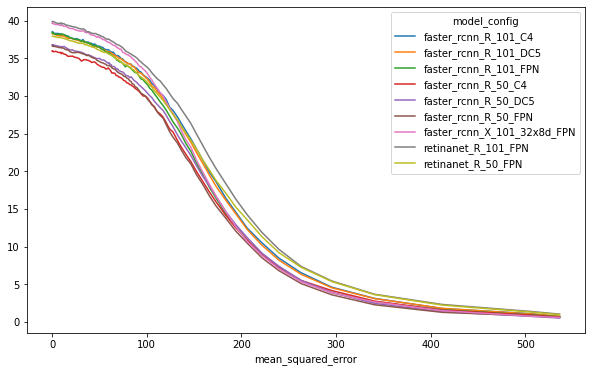

In [16]:
df.pivot(index='mean_squared_error', columns='model_config', values='AP').plot();

model_config
faster_rcnn_R_101_C4           AxesSubplot(0.125,0.125;0.775x0.755)
faster_rcnn_R_101_DC5          AxesSubplot(0.125,0.125;0.775x0.755)
faster_rcnn_R_101_FPN          AxesSubplot(0.125,0.125;0.775x0.755)
                                               ...                 
faster_rcnn_X_101_32x8d_FPN    AxesSubplot(0.125,0.125;0.775x0.755)
retinanet_R_101_FPN            AxesSubplot(0.125,0.125;0.775x0.755)
retinanet_R_50_FPN             AxesSubplot(0.125,0.125;0.775x0.755)
Length: 9, dtype: object

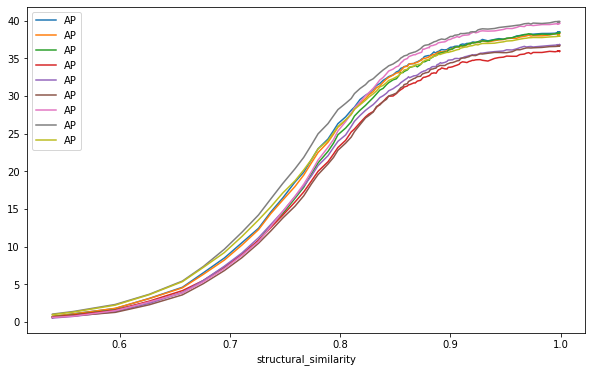

In [17]:
df.groupby('model_config').plot(x='structural_similarity', y='AP', ax=plt.gca())